**This notebook aims to present the Qolmat repo through an example of a multivariate time series.
In Qolmat, a few data imputation methods are implemented as well as a way to evaluate their performance.**

First, import some useful librairies

In [1]:
import warnings
# warnings.filterwarnings('error')

In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scipy
np.random.seed(1234)
import pprint
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as plticker

tab10 = plt.get_cmap("tab10")

from typing import Optional

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor


import sys
# sys.path.append("../../")
from qolmat.benchmark import comparator, missing_patterns
from qolmat.benchmark.utils import kl_divergence
from qolmat.imputations import imputers
from qolmat.utils import data, utils, plot
# from qolmat.drawing import display_bar_table


### **I. Load data**

The dataset `Beijing` is the Beijing Multi-Site Air-Quality Data Set. It consists in hourly air pollutants data from 12 chinese nationally-controlled air-quality monitoring sites and is available at https://archive.ics.uci.edu/ml/machine-learning-databases/00501/.
This dataset only contains numerical vairables.

In [3]:
# df_data = data.get_data_corrupted("Beijing", ratio_masked=.2, mean_size=120)

# cols_to_impute = ["TEMP", "PRES", "DEWP", "NO2", "CO", "O3", "WSPM"]
# cols_to_impute = df_data.columns[df_data.isna().any()]
# cols_to_impute = ["TEMP", "PRES"]


The dataset `Artificial` is designed to have a sum of a periodical signal, a white noise and some outliers.

In [4]:
df_data = data.get_data_corrupted("Artificial", ratio_masked=.2, mean_size=10)
cols_to_impute = ["signal"]

Let's take a look at variables to impute. We only consider a station, Aotizhongxin.
Time series display seasonalities (roughly 12 months).

In [5]:
n_stations = len(df_data.groupby("station").size())
n_cols = len(cols_to_impute)

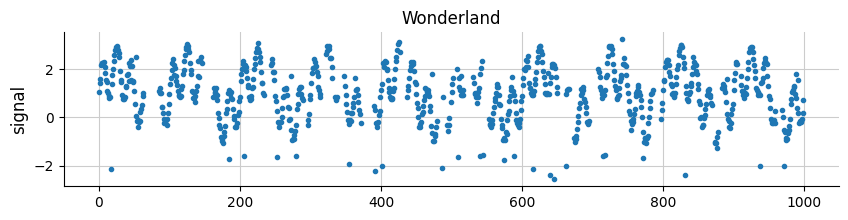

In [6]:
fig = plt.figure(figsize=(10 * n_stations, 2 * n_cols))
for i_station, (station, df) in enumerate(df_data.groupby("station")):
    df_station = df_data.loc[station]
    for i_col, col in enumerate(cols_to_impute):
        fig.add_subplot(n_cols, n_stations, i_col * n_stations + i_station + 1)
        plt.plot(df_station[col], '.', label=station)
        # break
        plt.ylabel(col, fontsize=12)
        if i_col == 0:
            plt.title(station)
plt.show()

### **II. Imputation methods**

This part is devoted to the imputation methods. The idea is to try different algorithms and compare them.

<u>**Methods**</u>:
All presented methods are group-wise: here each station is imputed independently. For example ImputerMean computes the mean of each variable in each station and uses the result for imputation; ImputerInterpolation interpolates termporal signals corresponding to each variable on each station.

<u>**Hyperparameters' search**</u>:
Some methods require hyperparameters. The user can directly specify them, or rather determine them through an optimization step using the `search_params` dictionary. The keys are the imputation method's name and the values are a dictionary specifying the minimum, maximum or list of categories and type of values (Integer, Real, Category or a dictionary indexed by the variable names) to search.
In pratice, we rely on a cross validation to find the best hyperparams values minimizing an error reconstruction.

In [7]:
imputer_mean = imputers.ImputerMean(groups=["station"])
imputer_median = imputers.ImputerMedian(groups=["station"])
imputer_mode = imputers.ImputerMode(groups=["station"])
imputer_locf = imputers.ImputerLOCF(groups=["station"])
imputer_nocb = imputers.ImputerNOCB(groups=["station"])
imputer_interpol = imputers.ImputerInterpolation(groups=["station"], method="linear")
imputer_spline = imputers.ImputerInterpolation(groups=["station"], method="spline", order=2)
imputer_shuffle = imputers.ImputerShuffle(groups=["station"])
imputer_residuals = imputers.ImputerResiduals(groups=["station"], period=7, model_tsa="additive", extrapolate_trend="freq", method_interpolation="linear")

imputer_rpca = imputers.ImputerRPCA(groups=["station"], columnwise=True, period=100, max_iter=100, tau=2, lam=.3)
imputer_rpca_opti = imputers.ImputerRPCA(groups=["station"], columnwise=True, period=365, max_iter=100)

imputer_ou = imputers.ImputeEM(groups=["station"], method="multinormal", max_iter_em=34, n_iter_ou=15, strategy="ou")
imputer_tsou = imputers.ImputeEM(groups=["station"], method="VAR1", strategy="ou", max_iter_em=34, n_iter_ou=15)
imputer_tsmle = imputers.ImputeEM(groups=["station"], method="VAR1", strategy="mle", max_iter_em=34, n_iter_ou=15)


imputer_knn = imputers.ImputerKNN(groups=["station"], k=10)
imputer_iterative = imputers.ImputerMICE(groups=["station"], estimator=LinearRegression(), sample_posterior=False, max_iter=100, missing_values=np.nan)
impute_regressor = imputers.ImputerRegressor(
  HistGradientBoostingRegressor(), cols_to_impute=cols_to_impute
)
impute_stochastic_regressor = imputers.ImputerStochasticRegressor(
  HistGradientBoostingRegressor(), cols_to_impute=cols_to_impute
)

dict_imputers = {
    "mean": imputer_mean,
    # "median": imputer_median,
    # "mode": imputer_mode,
    "interpolation": imputer_interpol,
    # "spline": imputer_spline,
    # "shuffle": imputer_shuffle,
    # "residuals": imputer_residuals,
    "OU": imputer_ou,
    "TSOU": imputer_tsou,
    "TSMLE": imputer_tsmle,
    "RPCA": imputer_rpca,
    # "RPCA_opti": imputer_rpca_opti,
    # "locf": imputer_locf,
    # "nocb": imputer_nocb,
    # "knn": imputer_knn,
    # "iterative": imputer_iterative,
}
n_imputers = len(dict_imputers)

search_params = {
    "RPCA_opti": {
        "tau": {"min": .5, "max": 5, "type":"Real"},
        "lam": {"min": .1, "max": 1, "type":"Real"},
    }
}

ratio_masked = 0.1

In order to compare the methods, we $i)$ artificially create missing data (for missing data mechanisms, see the docs); $ii)$ then impute it using the different methods chosen and $iii)$ calculate the reconstruction error. These three steps are repeated a number of times equal to `n_splits`. For each method, we calculate the average error and compare the final errors.

<p align="center">
    <img src="../../docs/images/comparator.png"  width=50% height=50%>
</p>


Concretely, the comparator takes as input a dataframe to impute, a proportion of nan to create, a dictionary of imputers (those previously mentioned), a list with the columns names to impute, a generator of holes specifying the type of holes to create and the search dictionary search_params for hyperparameter optimization.

Note these metrics compute reconstruction errors; it tells nothing about the distances between the "true" and "imputed" distributions.

In [8]:
generator_holes = missing_patterns.EmpiricalHoleGenerator(n_splits=2, groups=["station"], ratio_masked=ratio_masked)

comparison = comparator.Comparator(
    dict_imputers,
    cols_to_impute,
    generator_holes = generator_holes,
    n_calls_opt=10,
    search_params=search_params,
)
results = comparison.compare(df_data)
results

Tested model: ImputerMean
Tested model: ImputerInterpolation
Tested model: ImputeEM
Tested model: ImputeEM
Tested model: ImputeEM
Tested model: ImputerRPCA


,,mean,interpolation,OU,TSOU,TSMLE,RPCA
rmse,signal,1.241103,0.913554,1.538748,1.482250,1.083478,1.419723
mae,signal,1.010423,0.633836,1.255326,1.089997,0.879417,1.186370
wmape,signal,0.711891,0.526392,0.873097,0.884865,0.778890,1.000000
kl,signal,30.081765,1.845888,0.654668,0.430481,23.765243,31.249108


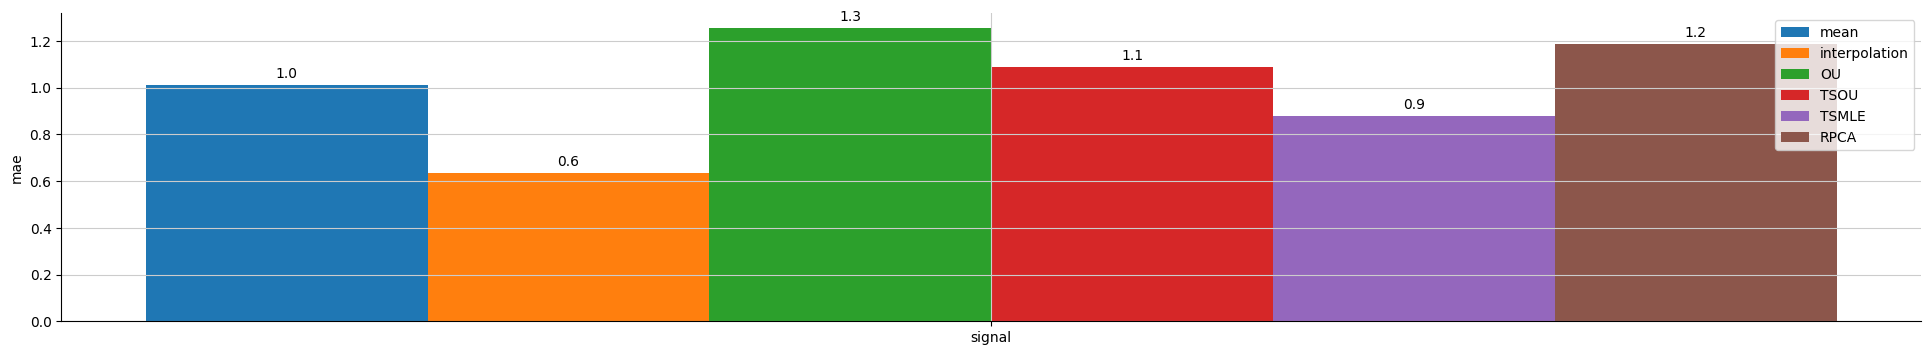

In [9]:
fig = plt.figure(figsize=(24, 4))
plot.multibar(results.loc["mae"], decimals=1)
plt.ylabel("mae")
plt.show()

### **IV. Comparison of methods**

We now run just one time each algorithm on the initial corrupted dataframe and compare the different performances through multiple analysis.

In [10]:
df_plot = df_data[cols_to_impute]

In [11]:
dfs_imputed = {name: imp.fit_transform(df_plot) for name, imp in dict_imputers.items()}

In [12]:
station = df_plot.index.get_level_values("station")[0]
df_station = df_plot.loc[station]
dfs_imputed_station = {name: df_plot.loc[station] for name, df_plot in dfs_imputed.items()}

Let's look at the imputations.
When the data is missing at random, imputation is easier. Missing block are more challenging.

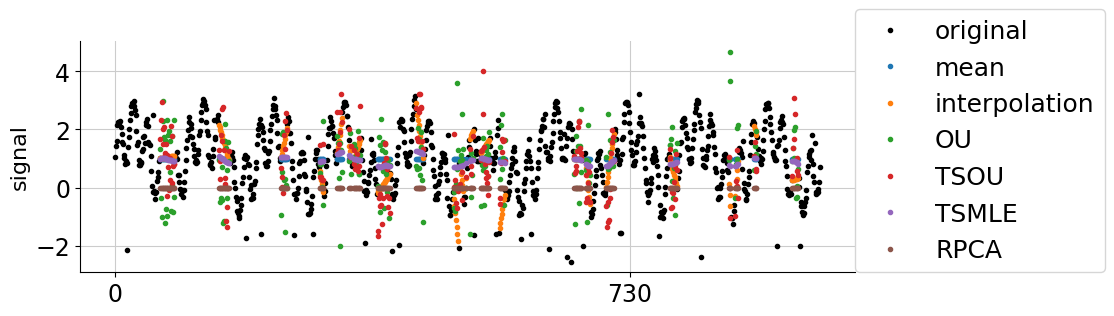

In [13]:
for col in cols_to_impute:
    fig, ax = plt.subplots(figsize=(10, 3))
    values_orig = df_station[col]

    plt.plot(values_orig, ".", color='black', label="original")

    for ind, (name, model) in enumerate(list(dict_imputers.items())):
        values_imp = dfs_imputed_station[name][col].copy()
        values_imp[values_orig.notna()] = np.nan
        plt.plot(values_imp, ".", color=tab10(ind), label=name, alpha=1)
    plt.ylabel(col, fontsize=16)
    plt.legend(loc=[1, 0], fontsize=18)
    loc = plticker.MultipleLocator(base=2*365)
    ax.xaxis.set_major_locator(loc)
    ax.tick_params(axis='both', which='major', labelsize=17)
    plt.show()


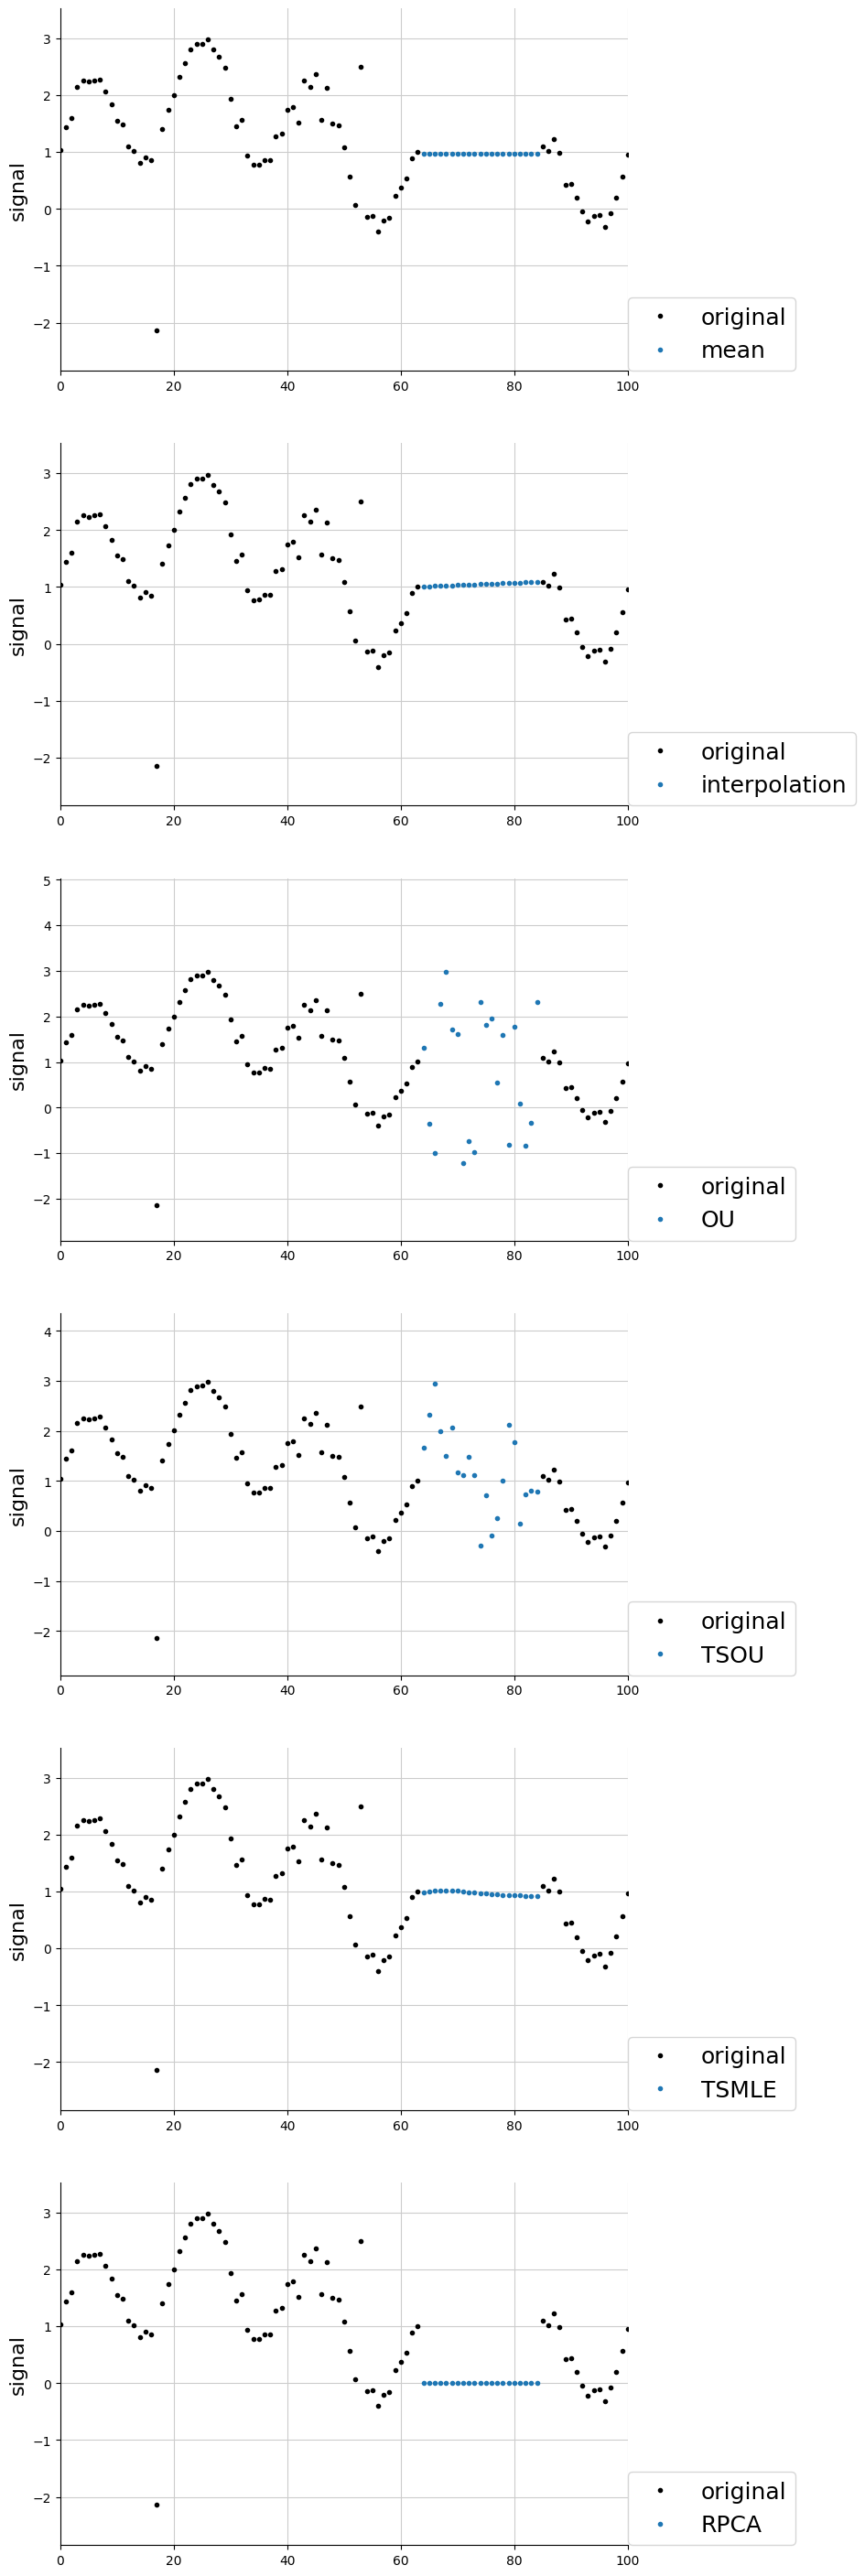

In [14]:
n_columns = len(df_plot.columns)
n_imputers = len(dict_imputers)

fig = plt.figure(figsize=(8 * n_columns, 6 * n_imputers))
i_plot = 1
for name_imputer in dict_imputers:
    for col in df_plot:

        fig.add_subplot(n_imputers, n_columns, i_plot)
        values_orig = df_station[col]

        plt.plot(values_orig, ".", color='black', label="original")
        #plt.plot(df.iloc[870:1000][col], markers[0], color='k', linestyle='-' , ms=3)

        values_imp = dfs_imputed_station[name_imputer][col].copy()
        values_imp[values_orig.notna()] = np.nan
        plt.plot(values_imp, ".", color=tab10(0), label=name_imputer, alpha=1)
        plt.ylabel(col, fontsize=16)
        if i_plot % n_columns == 0:
            plt.legend(loc=[1, 0], fontsize=18)
        loc = plticker.MultipleLocator(base=2*365)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='both', which='major', labelsize=17)
        i_plot += 1
        plt.xlim(0, 100)
plt.savefig("figures/imputations_benchmark.png")
plt.show()


**IV.a. Covariance**

We first check the covariance. We simply plot one variable versus one another.
One observes the methods provide similar visual resuls: it's difficult to compare them based on this criterion.

In [15]:
for i_model, model in enumerate(dict_imputers.keys()):
    fig, axs = plt.subplots(1, len(cols_to_impute)-1, figsize=(4 * (len(cols_to_impute)-1), 4))
    df_imp = dfs_imputed_station[model]
    for i in range(len(cols_to_impute)-1):
        plot.compare_covariances(df_station, df_imp, cols_to_impute[i], cols_to_impute[i+1], axs, color=tab10(i_model))
        axs.set_title(f"imputation method: {model}", fontsize=20)
    plt.show()

ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x400 with 0 Axes>

**IV.b. Auto-correlation**

We are now interested in th eauto-correlation function (ACF). As seen before, time series display seaonal patterns.
[Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) is the correlation of a signal with a delayed copy of itself as a function of delay. Informally, it is the similarity between observations of a random variable as a function of the time lag between them.

The idea is the AFC to be similar between the original dataset and the imputed one.
Fot the TEMP variable, one sees the good reconstruction for all the algorithms.
On th econtrary, for the PRES variable, all methods overestimates the autocorrelation of the variables, especially the RPCA one.
Finally, for the DEWP variable, the methods cannot impute to obtain a behavior close to the original: the autocorrelation decreases to linearly.

In [ ]:
from statsmodels.tsa.stattools import acf

palette = sns.dark_palette("b", n_colors=len(dict_i), reverse=False)
sns.set_palette(palette)
markers = ["o", "s", "*", "D", "P", ">", "^", "d"]

fig, axs = plt.subplots(1, len(cols_to_impute), figsize=(16, 2))
for i, col in enumerate(cols_to_impute):
    axs[i].plot(acf(df_station[col].dropna()), color="k", marker=markers[0], lw=0.8)
    for j, (name, df) in enumerate(dfs_imputed_station.items()):
        axs[i].plot(acf(df[col]), marker=markers[j+1], lw=0.8)
    axs[i].set_xlabel("Lags [days]", fontsize=15)
    axs[i].set_ylabel("Correlation", fontsize=15)
    axs[i].set_ylim([0.5, 1])
    axs[i].set_title(col, fontsize=15)
axs[-1].legend(["Original dataset"] +  list(dfs_imputed.keys()), loc=[1, 0])
sns.despine()

**IV.b. Distances between distributions**

We are now interested in a way for quantifying the distance between two distributions.
Until now, we look at the reconstruction error, whatever the distributions.

There is a plethora of methods to quantify the distance between distributions $P$ and $Q$.
For instance, those based on the information theory as for instance, the well-known [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). A simple interpretation of the KL divergence of $P$ from $Q$ is the expected excess surprise from using $Q$ as a model when the actual distribution is $P$.

A drawback with this divergence is it ignores the underlying geometry of the space (the KL divergence is somewhat difficult to intuitively interpret).
As a remedy, we consider a second metric, the [Wasserstein distance](https://en.wikipedia.org/wiki/Wasserstein_metric), a distance function defined between probability distributions on a given metric space $M$.

To understand one of the differences between these two quantities, let us look at this simple example.
The KL between the 2 distributions on the left is the same as that of the 2 distributions on the right: the KL divergence does not take into account the underlying metric space. Conversely, the Wasserstein metric is larger for those on the left since the "transport" is greater than for those on the right.

<p align="center">
    <img src="../../docs/images/KL_wasser.png"  width=50% height=50%>
</p>


In [ ]:
df_kl = pd.DataFrame(np.nan, index=dfs_imputed_station.keys(), columns=cols_to_impute)
for model, df_imputed in dfs_imputed_station.items():
    for col in cols_to_impute:
        kl = kl_divergence(df_station[[col]].dropna(how="all"), df_imputed[[col]]).iloc[0]
        df_kl.loc[model, col] = kl

plot.display_bar_table(df_kl, ylabel="KL divergence")

In [ ]:
df_wasserstein = pd.DataFrame(np.nan, index=dfs_imputed_station.keys(), columns=cols_to_impute)
for model, df_imputed in dfs_imputed_station.items():
    for col in cols_to_impute:
        wasserstein = scipy.stats.wasserstein_distance(df_station[col].dropna(how="all"), df_imputed[col])
        df_wasserstein.loc[model, col] = wasserstein

plot.display_bar_table(df_wasserstein, ylabel="Wasserstein distance")